In [1]:
import scipy.io
from scipy.io import loadmat

#replicating from the data that Talia sent over
inp_data = loadmat("FK_ompa_04s.mat")
matlab_ompa_results = loadmat("FK_26_27_s_nospic_results.mat")

In [2]:
import pandas as pd

def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "nitrate", "silicate", "spiciness"])
    df["mass"] = 1
    return df

#                                   temp       sal         oxy     PO4     NO3    Si      spic
CW13_FK =        ["13CW_FK",       12.54,    34.98,       0.59,   2.73,   23.2,   50,     1.58]
NEPIW_FK =       ["NEPIW_FK",       9.56,    34.80,       0.64,   3.1,    35,     50,     0.894]
AAIW =           ["AAIW",        6.03,    34.70,       4.8,    3.48,   46.8,   60,     0.418]

intermediatewaters_FK_endmemberdf = prepare_endmember_df([CW13_FK, NEPIW_FK, AAIW])

falkor_df = pd.DataFrame({
    'lat': inp_data['lat'].flatten(),
    'long': inp_data['long'].flatten(),
    'pdens': inp_data['pdens'].flatten(),
    'pressure': inp_data['press'].flatten(),
    'Iodate': inp_data['Iodate'].flatten(),
    'Iodide': inp_data['Iodide'].flatten(),
    'nitrate': inp_data['NO2'].flatten(),
    'oxygen': inp_data['oxy'].flatten(),
    'phosphate': inp_data['ph'].flatten(),
    'conservative_temp': inp_data['ptemp'].flatten(),
    'absolute_salinity': inp_data['sal'].flatten(),
    'spiciness': inp_data['pvort'].flatten()
})
falkor_df["mass"] = 1.0

In [3]:
%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

intermediatewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["pdens"] >= 26.0)
                                                     & (falkor_df["pdens"] <= 27.0)])

evansorig_convertedparamgroups = [
    pyompa.ConvertedParamGroup(groupname="phosphate_remin",
                               conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
                               always_positive=True)
]

evansorig_paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
    "spiciness": 7.0,
    "mass": 24.0,
    "oxygen": 7.0,
    "phosphate": 2.0
}

evansorig_settings_nospiciness = {
    "param_names": ["conservative_temp", "absolute_salinity", "oxygen", "phosphate", "mass"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": False,
    "standardize_by_watertypes": True
}

##
#G2
#   23.2964    1.3502  -24.6466         0
#   25.9352   -4.5105  -21.4247         0
#   -4.1137   -3.9688    8.0825 -492.4803
#   -1.9911   -0.0178    2.0088    5.3332
#   24.0000   24.0000   24.0000         0

#
#mean
#    9.3767   34.8267    2.0100    3.1033    1.0000
#std
#    3.2589    0.1419    2.4163    0.3750         0

intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  **evansorig_settings_nospiciness).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")

I'm assuming that the index encoding mass is: [4]
Std used for normalization: [3.25886995 0.14189198 2.41634021 0.37501111 1.        ]
Mean used for normalization: [ 9.37666667 34.82666667  2.01        3.10333333  0.        ]
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'phosphate', 'mass']
param weighting: [24. 24.  7.  2. 24.]
effective weighting: [   2.25983735 1192.05298013    1.19889701   14.22137947   24.        ]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'oxygen': [-170], 'phosphate': [1.0]}))])
Matrix A:
Trying convertedvariable sign constraint: [1]
status: optimal
optimal value 10627.4558588336
Original weighted sum squares: 10627.455858848882
Post fix weighted sum squared: 10627.455858864303
status: optimal
optimal value 10627.4558588336
Original weighted sum squares: 10627.455858848882
Post fix weighted sum squared: 10627.455858864303
objective: 10627.455858864305


In [4]:
import numpy as np

np.max(np.abs(intermediate_falkordf_ompasoln.endmember_fractions - matlab_ompa_results['A'].T))

1.963984530561902e-12

In [5]:
np.max(np.abs(intermediate_falkordf_ompasoln.groupname_to_totalconvertedvariable['phosphate_remin']*170
- matlab_ompa_results['biogeo'].flatten()))

3.34199222248199e-14

In [10]:
np.max(np.abs(intermediate_falkordf_ompasoln.param_residuals - matlab_ompa_results['err'].T))

5.118749868415762e-11

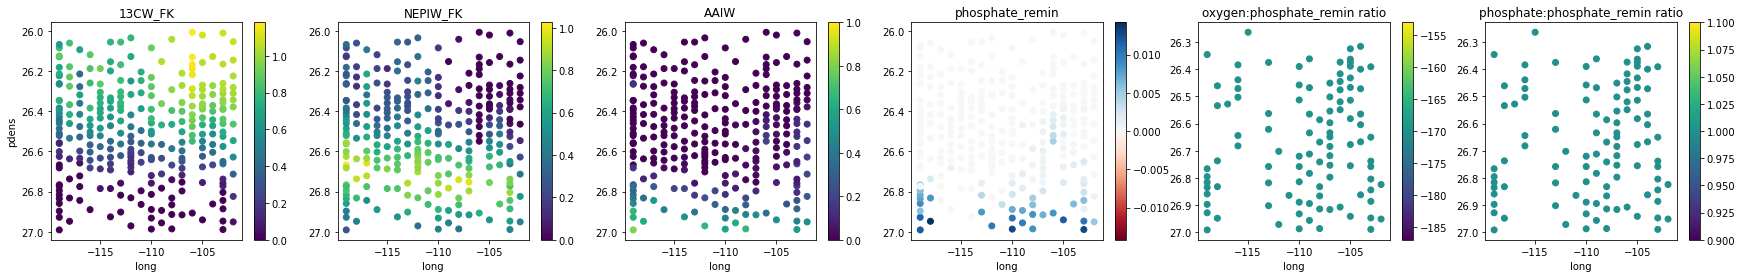

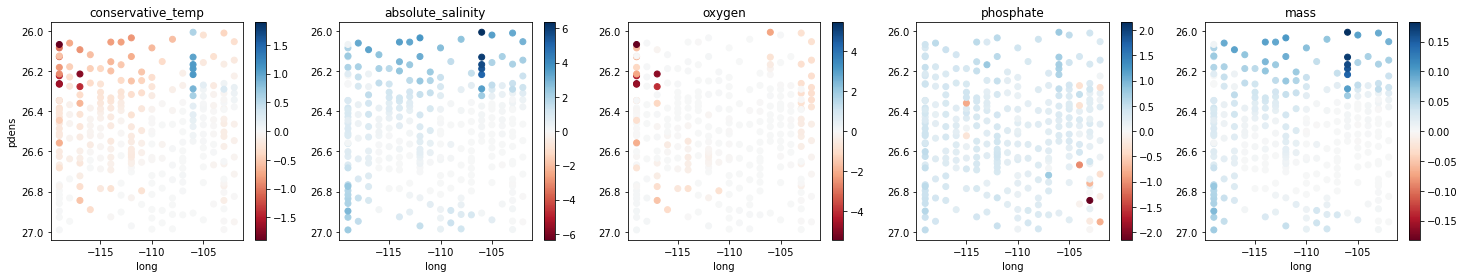

In [8]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
plot_ompasoln_endmember_fractions(ompa_soln=intermediate_falkordf_ompasoln,
                                  xaxis_colname="long",
                                  yaxis_colname=yaxis_colname)
plot_ompasoln_residuals(ompa_soln=intermediate_falkordf_ompasoln,
                        xaxis_colname="long",
                        yaxis_colname=yaxis_colname)

